# Wavelets decomposition

- author Sylvie Dagoret-Campagne
- creation date August 14th 2020
- update : August 15th 2020
- update : August 17th 2020 : 2D plot of coefficients


Decomposition up to max = 9 levels

In [715]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys

import matplotlib.colors as colors
import matplotlib.cm as cmx

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [716]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [717]:
sys.path.append("../../tools/atmanalyticsim") # go to parent dir

In [718]:
import libatmscattering as atm

In [719]:
import pywt

In [720]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.rcParams['font.size'] = 18

In [721]:
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)

In [722]:
def thresh_hard_sparse(x, k):
    """
    Keep only k largest entries of x and return their indices.
    Parameters
    ----------
    x : numpy array
        Numpy array to be thresholded
    k : int
        Number of largest entries in absolute value to keep
    Notes
    """
    _x = x.copy()
    ind = np.argpartition(abs(_x), -k, axis=None)[-k:]
    ind = np.unravel_index(ind, _x.shape)
    ind_del = np.ones(_x.shape, dtype=bool)
    ind_del[ind] = False
    _x[ind_del] = 0
    return ind, _x

In [723]:
def index_to_level(indexes,coeffs_shapes):
    """
    Compute the level number corresponding to the indices
    Parameters:
    ----------
    indexes : numpy array of indices
    coeffs_shape : structure of coefficients of pywt from 
    
    return the level number of each indexes (numpy array)
 
    """
    
    
    nlevels=len(coeffs_shapes)
    sum_nb_coeffs=np.zeros(nlevels)

    # first compute cumulated threshold indexes over level
    for ilevel in np.arange(nlevels):
        if ilevel==0:
            sum_nb_coeffs[ilevel]=coeffs_shapes[ilevel][0]
        else:
            sum_nb_coeffs[ilevel]=sum_nb_coeffs[ilevel-1]+coeffs_shapes[ilevel]['d'][0]
            
  
            
    # for each index compute the level
    indexes_levels=np.zeros_like(indexes)
    
    for ilevel in np.arange(nlevels):
       
        if ilevel==0:
            #indexes_levels=np.where(indexes<int(sum_nb_coeffs[ilevel]),ilevel,0)
            sel_indexes=np.where(indexes<int(sum_nb_coeffs[ilevel]))
            indexes_levels[sel_indexes[0]]=ilevel                     
        else:
            #indexes_levels=np.where(np.logical_and(indexes>=int(sum_nb_coeffs[ilevel-1]),
            #                                       indexes<=int(sum_nb_coeffs[ilevel]))
            #                                       ,ilevel,0)
            sel_indexes=np.where(
                np.logical_and(indexes>=int(sum_nb_coeffs[ilevel-1]),
                               indexes<int(sum_nb_coeffs[ilevel])))
            indexes_levels[sel_indexes[0]]=ilevel                          
                                                   
    return indexes_levels

In [724]:
DATADIR="../../data/atm"

In [725]:
atmospheric_basename_files=os.listdir(DATADIR)

In [726]:
atmospheric_basename_files

['lsst_atm_10year_bintab.parquet',
 'lsst_atm_10year_01.fits',
 'lsst_atm_10year_bigimg.fits',
 'lsst_atm_10year_07.fits',
 'lsst_atm_10year_06.fits',
 'lsst_atm_10year_10.fits',
 'lsst_atm_10year_09.fits',
 'lsst_atm_10year_bintab.fits',
 'lsst_atm_10year_05.fits',
 'lsst_atm_10year_04.fits',
 'lsst_atm_10year_bintab_small.fits',
 'lsst_atm_10year_08.fits',
 'lsst_atm_10year_03.fits',
 '.ipynb_checkpoints',
 'lsst_atm_10year_02.fits']

In [727]:
input_file=os.path.join(DATADIR,'lsst_atm_10year_bigimg.fits')

In [728]:
hdu = fits.open(input_file)

In [729]:
hdr=hdu[0].header
data=hdu[0].data

In [730]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  958                                                  
NAXIS2  =                 3651                                                  
NBATMSIM=                 3650                                                  
ID_NUM  =                    0                                                  
ID_YEAR =                    1                                                  
ID_AM   =                    2                                                  
ID_VAOD =                    3                                                  
ID_PWV  =                    4                                                  
ID_O3   =                    5                                                  
ID_CLD  =                   

In [731]:
NbAtmSimul=hdr['NBATMSIM']
idx_out_num=hdr['ID_NUM']
idx_out_year=hdr['ID_YEAR']
idx_out_am=hdr['ID_AM']
idx_out_vaod=hdr['ID_VAOD']
idx_out_pwv=hdr['ID_PWV']
idx_out_o3=hdr['ID_O3']
idx_out_cld=hdr['ID_CLD']
idx_out_res=hdr['ID_RES']

In [732]:
num=data[1:,idx_out_num]
year=data[1:,idx_out_year]
airmass=data[1:,idx_out_year]
vaod=data[1:,idx_out_vaod] # vertical aerosol depth
pwv=data[1:,idx_out_pwv]   # precipitable water vapor (mm)
o3=data[1:,idx_out_o3]     # ozone
cld=data[1:,idx_out_cld]   # clouds (not used)

In [733]:
# Extract wavelength Wavelength
wl=data[0,idx_out_res:]
transm=data[1:,idx_out_res:]

In [734]:
NWL=wl.shape[0]

In [735]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

# Prepare data

In [736]:
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=o3[:,np.newaxis]

In [737]:
Y=np.concatenate((vaodarr,pwvarr,o3arr),axis=1)

In [738]:
WLMINSEL=340.
WLMAXSEL=1100.

In [739]:
indexes_selected=np.where(np.logical_and(wl>=WLMINSEL,wl<=WLMAXSEL))[0]

In [740]:
# need even number of bins
if len(indexes_selected)%2:
    indexes_selected=indexes_selected[:-1]

In [741]:
len(indexes_selected)

760

In [742]:
wl=wl[indexes_selected]
transm=transm[:,indexes_selected]

In [743]:
WLMIN=wl[0]
WLMAX=wl[-1]

In [744]:
index_atm=2

In [745]:
#transm0=transm[0]*0.96
transm0=transm[index_atm]

In [746]:
od=atm.RayOptDepth_adiabatic(wl, altitude=atm.altitude0, costh=1/1.2)
att_rayleigh=np.exp(-od)

Text(0, 0.5, 'att (mag)')

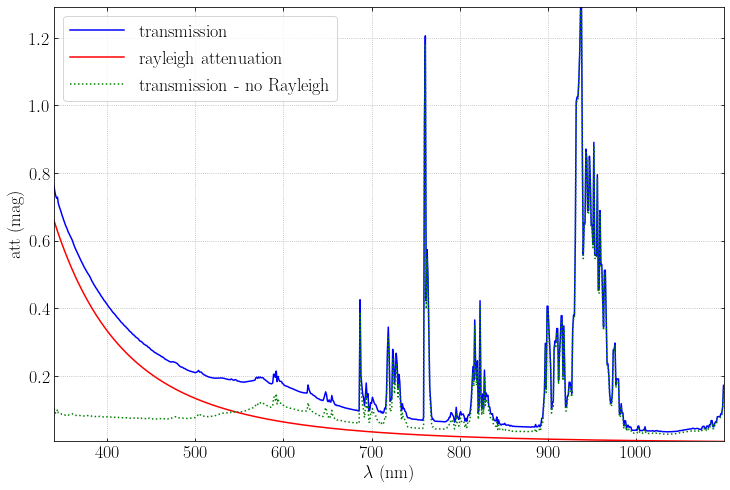

In [747]:
ax = plt.subplot(111)
ax.plot(wl,-2.5*np.log10(transm0),'b-',label="transmission")
ax.plot(wl,-2.5*np.log10(att_rayleigh),'r-',label="rayleigh attenuation")
ax.plot(wl,-2.5*np.log10(transm0/att_rayleigh),'g:',label="transmission - no Rayleigh")
ax.legend()
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("att (mag)")

# wavelet decomposition

In [748]:
# correction from Rayleigh
t=wl
h=-2.5*np.log10(transm0/att_rayleigh)

In [749]:
print("number of samples :",len(h))

number of samples : 760


# Wavelet

In [750]:
wname = "db1"
w = pywt.Wavelet(wname)

In [751]:
print(w)

Wavelet db1
  Family name:    Daubechies
  Short name:     db
  Filters length: 2
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [752]:
wavelet = pywt.Wavelet(wname)

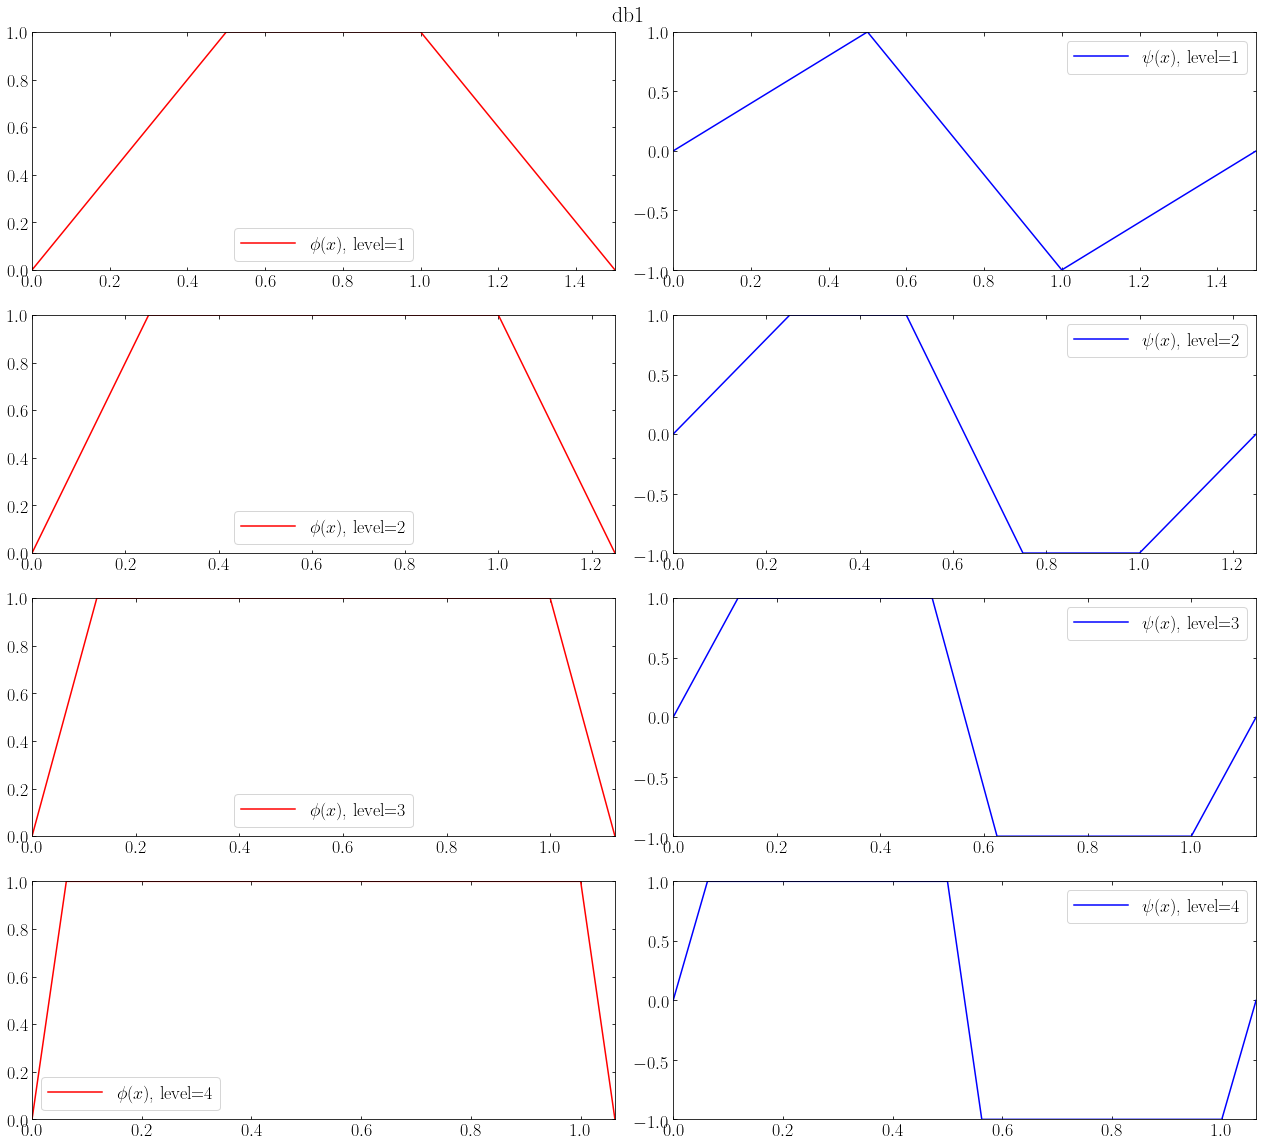

In [753]:
nlevel=4
nimages=2*nlevel

fig = plt.figure(figsize=(18,4*nlevel))
iframe0=nlevel*100+ 20

for ilevel in np.arange(1,nlevel+1):
    phi, psi, x = wavelet.wavefun(level=ilevel)
    iframe=iframe0+(ilevel-1)*2+1
    label="$\phi(x)$, level={}".format(ilevel)
    ax = plt.subplot(iframe)
    ax.plot(x,phi,'r-',label=label)
    ax.legend()
    iframe=iframe0+(ilevel-1)*2+2
    label="$\psi(x)$, level={}".format(ilevel)
    ax = plt.subplot(iframe)
    ax.plot(x,psi,'b-',label=label)
    ax.legend()
plt.suptitle(wname,Y=1)
plt.tight_layout()

## Properties

In [754]:
print("wavelet name \t : ",w.name)
print("wavelet short_family_name \t : ",w.short_family_name)
print("wavelet family_name \t : ",w.family_name)
print("wavelet dec_len \t: ", int(w.dec_len))
print("wavelet orthogonal \t: ",  w.orthogonal)
print("wavelet bi-orthogonal \t: ",  w.biorthogonal)
print("wavelet symmetry \t: ", w.symmetry)
print("wavelet vanishing_moments_phi\t: ", w.vanishing_moments_phi)
print("wavelet vanishing_moments_psi\t: ", w.vanishing_moments_psi)

wavelet name 	 :  db1
wavelet short_family_name 	 :  db
wavelet family_name 	 :  Daubechies
wavelet dec_len 	:  2
wavelet orthogonal 	:  True
wavelet bi-orthogonal 	:  True
wavelet symmetry 	:  asymmetric
wavelet vanishing_moments_phi	:  0
wavelet vanishing_moments_psi	:  1


### Max length

In [755]:
maxlvl=pywt.dwt_max_level(data_len=len(h), filter_len=w.dec_len)

In [756]:
print("max length = ",maxlvl)

max length =  9


## Wavelet decomposition

In [757]:
nlevels=maxlvl

In [758]:
coeffs = pywt.wavedec(h, w, level=nlevels,mode='zero')

In [759]:
len(coeffs)

10

In [760]:
coeffs[0]

array([2.11070673, 1.91002227])

In [761]:
coeffs[1]

array([-0.18253978,  1.91002227])

In [762]:
def coeff_to_image(coeffs):
    """
    Return an image on the coeff
    """
    
    Nlevels=len(coeffs)
    level_size=np.zeros(Nlevels)
    
    for ilevel in np.arange(Nlevels):
        print("ilevel= {} , size= {}".format(ilevel,coeffs[ilevel].shape[0]))
        level_size[ilevel]=coeffs[ilevel].shape[0]
        
    print(level_size)
    max_size=int(max(level_size))
    
    
    image=np.zeros((Nlevels, max_size))
    
    # loop on levels ( the y coordinate of the array)
    for ilevel in np.arange(Nlevels):
        # loop on coefficients in that slice
        the_size_level=level_size[ilevel]
        the_nb_elements_per_col=max_size/the_size_level
        
        print("ilevel = ",ilevel, 
              "the_size_level = ",the_size_level,
              " the_nb_elements_per_col = ",the_nb_elements_per_col)
        
        # loop on the x coordinate of the array)
        #for index in np.arange(max_size):
        #    colidx=(index-index%the_nb_elements_per_col)/the_nb_elements_per_col
        #    print("\t - ilevel = {} , index = {}, colidx = {}".format(ilevel,index,colidx))
            
            
    

In [763]:
coeff_to_image(coeffs)

ilevel= 0 , size= 2
ilevel= 1 , size= 2
ilevel= 2 , size= 3
ilevel= 3 , size= 6
ilevel= 4 , size= 12
ilevel= 5 , size= 24
ilevel= 6 , size= 48
ilevel= 7 , size= 95
ilevel= 8 , size= 190
ilevel= 9 , size= 380
[  2.   2.   3.   6.  12.  24.  48.  95. 190. 380.]
ilevel =  0 the_size_level =  2.0  the_nb_elements_per_col =  190.0
ilevel =  1 the_size_level =  2.0  the_nb_elements_per_col =  190.0
ilevel =  2 the_size_level =  3.0  the_nb_elements_per_col =  126.66666666666667
ilevel =  3 the_size_level =  6.0  the_nb_elements_per_col =  63.333333333333336
ilevel =  4 the_size_level =  12.0  the_nb_elements_per_col =  31.666666666666668
ilevel =  5 the_size_level =  24.0  the_nb_elements_per_col =  15.833333333333334
ilevel =  6 the_size_level =  48.0  the_nb_elements_per_col =  7.916666666666667
ilevel =  7 the_size_level =  95.0  the_nb_elements_per_col =  4.0
ilevel =  8 the_size_level =  190.0  the_nb_elements_per_col =  2.0
ilevel =  9 the_size_level =  380.0  the_nb_elements_per_col =

In [764]:
full_rec=pywt.waverec(coeffs, w)

coeffs[9] = np.zeros_like(coeffs[9])

rec_1=pywt.waverec(coeffs, w)

coeffs[8] = np.zeros_like(coeffs[8])
coeffs[7] = np.zeros_like(coeffs[7])

rec_2=pywt.waverec(coeffs, w)

coeffs[6] = np.zeros_like(coeffs[6])
coeffs[5] = np.zeros_like(coeffs[5])

rec_3=pywt.waverec(coeffs, w)

coeffs[4] = np.zeros_like(coeffs[4])
coeffs[3] = np.zeros_like(coeffs[3])

rec_4=pywt.waverec(coeffs, w)

coeffs[2] = np.zeros_like(coeffs[2])
coeffs[1] = np.zeros_like(coeffs[1])

rec_5=pywt.waverec(coeffs, w)


In [765]:
coeffs[0]

array([2.11070673, 1.91002227])

In [766]:
N=len(coeffs_shapes)
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

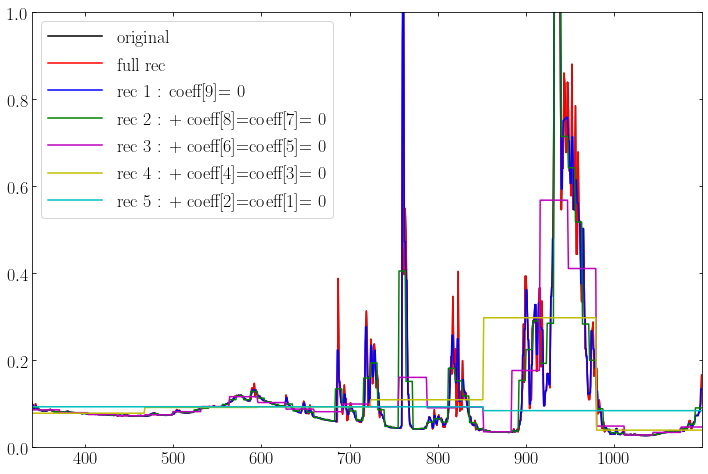

In [767]:
fig = plt.figure(figsize=(12,8))

ax = plt.subplot(111)

ax.plot(t,h,"k-",label="original")
ax.plot(t,full_rec,"r-",label="full rec")
ax.plot(t,rec_1,"b-",label="rec 1 : coeff[9]= 0")
ax.plot(t,rec_2,"g-",label="rec 2 : + coeff[8]=coeff[7]= 0")
ax.plot(t,rec_3,"m-",label="rec 3 : + coeff[6]=coeff[5]= 0")
ax.plot(t,rec_4,"y-",label="rec 4 : + coeff[4]=coeff[3]= 0")
ax.plot(t,rec_5,"c-",label="rec 5 : + coeff[2]=coeff[1]= 0")
ax.set_ylim(0,1)
ax.legend()

# Coefficients

In [768]:
w = pywt.Wavelet(wname)
coeffs = pywt.wavedec(h, w, level=nlevels)

In [769]:
len(coeffs) 

10

In [770]:
coeffs[0]

array([2.11070673, 3.88419371])

In [771]:
coeffs[1]

array([-0.18253978,  0.        ])

In [772]:
coeffs[8][-5:]

array([ 2.04893995e-04,  2.66772910e-03, -9.63215139e-03,  9.96100184e-05,
       -5.20192063e-02])

In [773]:
coeffs_vec, coeffs_slices, coeffs_shapes = pywt.ravel_coeffs(coeffs)

In [774]:
coeffs_vec.shape

(762,)

In [775]:
coeffs_vec[:5]

array([ 2.11070673,  3.88419371, -0.18253978,  0.        , -0.10604406])

In [776]:
coeffs_vec[-5:]

array([-1.47673718e-05, -1.46319065e-05, -1.44979310e-05, -1.43654264e-05,
       -4.50828876e-02])

In [777]:
coeffs_slices

[slice(None, 2, None),
 {'d': slice(2, 4, None)},
 {'d': slice(4, 7, None)},
 {'d': slice(7, 13, None)},
 {'d': slice(13, 25, None)},
 {'d': slice(25, 49, None)},
 {'d': slice(49, 97, None)},
 {'d': slice(97, 192, None)},
 {'d': slice(192, 382, None)},
 {'d': slice(382, 762, None)}]

In [778]:
coeffs_shapes

[(2,),
 {'d': (2,)},
 {'d': (3,)},
 {'d': (6,)},
 {'d': (12,)},
 {'d': (24,)},
 {'d': (48,)},
 {'d': (95,)},
 {'d': (190,)},
 {'d': (380,)}]

In [779]:
380+190+95+48+24+12+6+3+2+2

762

In [780]:
len(coeffs_shapes)

10

In [781]:
coeffs_shapes[0][0]

2

In [782]:
coeffs_shapes[1]['d'][0]

2

In [783]:
sum_nb_coeffs=0

for ilevel in np.arange(len(coeffs_shapes)):
    if ilevel==0:
        sum_nb_coeffs=coeffs_shapes[ilevel][0]
    else:
         sum_nb_coeffs+=coeffs_shapes[ilevel]['d'][0]
            
print('sum_nb_coeffs:'+str(sum_nb_coeffs))

sum_nb_coeffs:762


# UTILISATION DES 200 premiers coefficients

In [784]:
# UTILISATION DES 200 premiers coeff
n_coeffs = 200
indexes , coeffs_k = thresh_hard_sparse(coeffs_vec, n_coeffs)
new_coeffs = pywt.unravel_coeffs(coeffs_k, coeffs_slices, coeffs_shapes)
rec_signal = pywt.waverecn(new_coeffs,wname, mode = "zero")

In [785]:
len(indexes[0])

200

In [786]:
coeffs_k.shape

(762,)

In [787]:
len(indexes[0])

200

In [788]:
indexes[0][:50]

array([658, 153, 304, 539, 664,  32,  25,  49, 264,  47,  65, 305, 561,
       633,  77,  68, 706, 579, 159, 316, 697,  63, 133,  71, 506, 610,
       306, 558, 574, 618, 314, 315, 698, 625,   9, 696, 659, 338,  95,
       621, 140, 628,  13,  15, 508, 577, 576,  80, 575, 330])

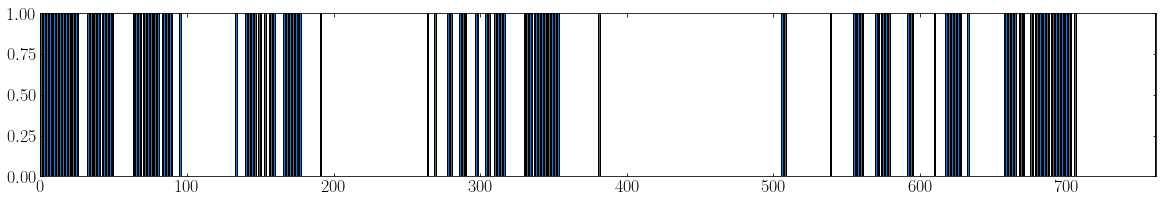

In [789]:
fig = plt.figure(figsize=(20,3))
ax = plt.subplot(111)
ax.hist(indexes[0],bins=sum_nb_coeffs);

In [790]:
# get level of indexes for color scatter plot
level_indexes=index_to_level(indexes[0],coeffs_shapes)

In [791]:
coeffs_k.shape

(762,)

In [792]:
coeffs_k[:5]

array([ 2.11070673,  3.88419371, -0.18253978,  0.        , -0.10604406])

In [793]:
coeffs_k[-5:]

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.04508289])

### Plot 200 first coefficients

In [794]:
N=len(coeffs_shapes)
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

Text(0.5, 1.0, ' highest values coefficients, nb coeffs:200')

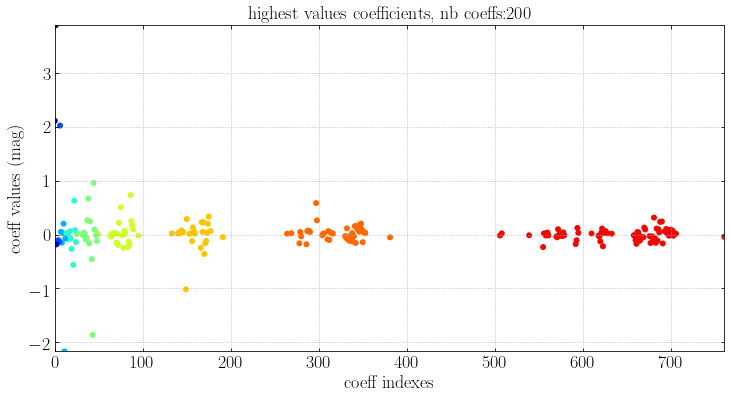

In [795]:
#plot

fig = plt.figure(figsize=(12,6))

ax = plt.subplot(111)

ax.scatter(indexes[0],coeffs_k[indexes[0]], marker = 'o', c=all_colors[level_indexes],edgecolors = 'none')
ax.grid()
ax.set_xlabel("coeff indexes")
ax.set_ylabel("coeff values (mag)")
ax.set_title(" highest values coefficients, nb coeffs:"+str(n_coeffs))

In [796]:
len(new_coeffs)

10

# plot the reconstruction with 200 coefficients

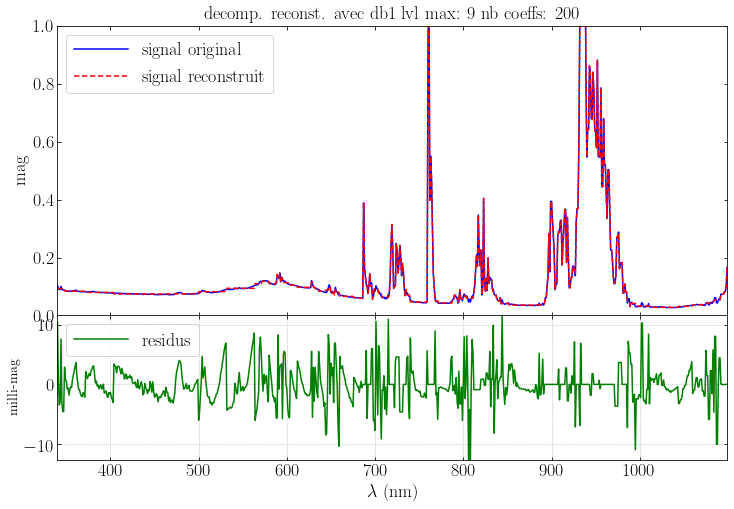

In [797]:
#plot

fig = plt.figure(figsize=(12,8))

gs = plt.GridSpec(2, 1, hspace=0, height_ratios=[1,1/2])

ax0 = fig.add_subplot(gs[0,:])
ax0.plot(t,h,"b",label='signal original')
ax0.plot(t,rec_signal,"r" ,label='signal reconstruit', linestyle='--')
ax0.legend(loc='upper left')
ax0.set_title('decomp. reconst. avec '+
              wname+
              ' lvl max: '+
              str(nlevels)+
              ' nb coeffs: '+
              str(n_coeffs))

ax0.set_xticklabels([])

ax0.set_ylim(0,1)
ax0.set_ylabel("mag")
#
#
ax1 = fig.add_subplot(gs[1,:])
ax1.plot(t,h-rec_signal,"g",label='residus')
ax1.legend(loc='upper left')
ax1.ticklabel_format(axis='y',style='sci',scilimits=(-3,-3))
ax1.yaxis.get_offset_text().set_visible(False)
#ax1.set_ylim([-10**(-6),10**(-6)])
ax1.set_xlabel("$\lambda$ (nm)")
#ax1.set_ylabel(r"$\times 10^{-3}$", fontsize=14)
ax1.set_ylabel(r"milli-mag", fontsize=14)
ax1.grid()
plt.show()

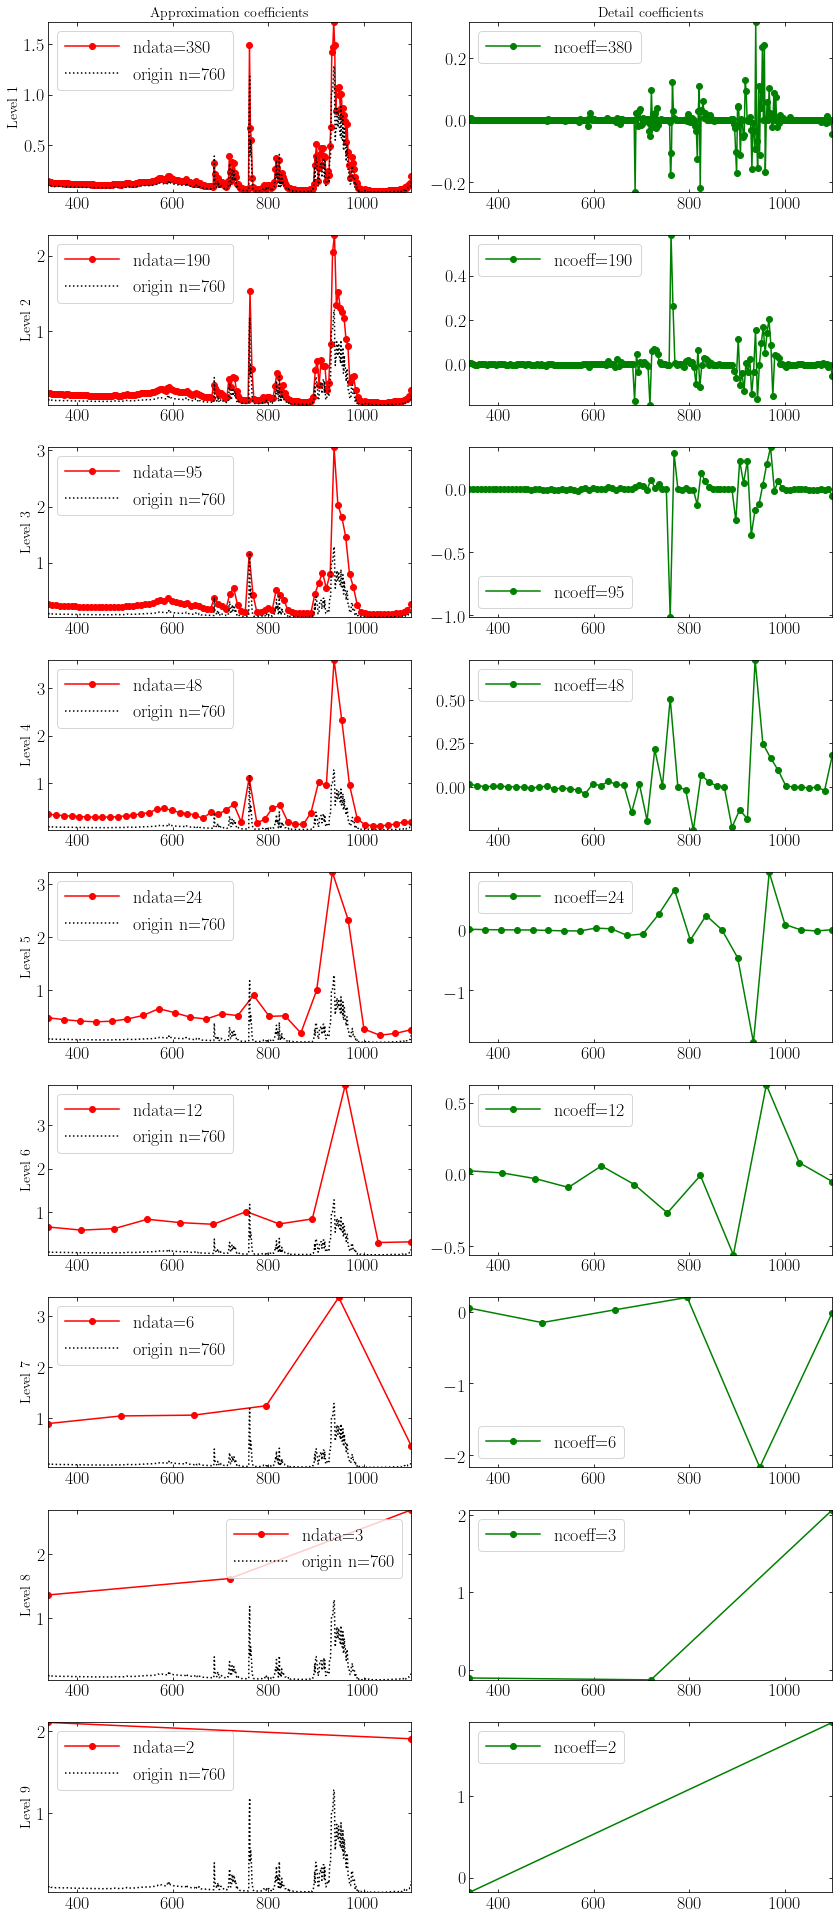

In [798]:
w = pywt.Wavelet(wname)
data = h

# number of levels
#maxlvl=pywt.dwt_max_level(data_len=len(data), filter_len=w.dec_len)

# limit to the number of levels chosen, here nlevels=6
maxlvl=nlevels

fig, axarr = plt.subplots(nrows=maxlvl, ncols=2, figsize=(12,3*maxlvl))

# loop on levels
for ii in range(maxlvl):
    (data, coeff_d) = pywt.dwt(data, wname, mode='zero')
    ndata=len(data)
    ncoeff=len(coeff_d)
    label_data="ndata={}".format(ndata)
    label_coeff="ncoeff={}".format(ncoeff)
    label_orig="origin n={}".format(len(h))
    
    X=np.linspace(WLMIN,WLMAX,len(data))
    
    axarr[ii, 0].plot(X,data, 'r-o',label=label_data)
    axarr[ii, 0].plot(t,h,"k:",label=label_orig)
    axarr[ii, 1].plot(X,coeff_d, 'g-o',label=label_coeff)
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
#    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
#    axarr[ii, 1].set_yticklabels([])
    axarr[ii,0].legend()
    axarr[ii,1].legend()
plt.tight_layout()
plt.show() 